In [279]:
import ee
import geemap
from sqlalchemy import create_engine  
from urllib.parse import quote
import geopandas as gpd
import matplotlib as plt
import os

ee.Initialize()

In [239]:
# postgres password and host from AWS server
dbpass = os.environ['DBPASS']
dbhost = os.environ['AWSIP']

In [240]:
# read data from postgres database
db_connection_url = "postgresql://admin:{}@{}:5432/postgres".format(quote(dbpass), dbhost)
con = create_engine(db_connection_url)
sql = "SELECT * FROM public.aus_border"

gdf = gpd.GeoDataFrame.from_postgis(sql, con)

<AxesSubplot:>

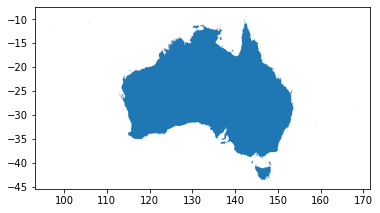

In [241]:
gdf.plot()

In [242]:
gdf.head()

,fid,geom,code,name,area_km,year
0,1,"MULTIPOLYGON (((96.91524 -12.15313, 96.91370 -...",AUS,Australia,7.688095e+06,2021


In [243]:
# convert the geopandas dataframe to ee geometry
border = geemap.geopandas_to_ee(gdf)

/home/rvalavi/miniconda3/envs/spatial/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [244]:
# get the satellite data
dataset = ee.ImageCollection('NOAA/GFS0P25')

In [245]:
dataset

In [246]:
# print the name of the bands
dataset.first().bandNames().getInfo()

['temperature_2m_above_ground',
 'specific_humidity_2m_above_ground',
 'relative_humidity_2m_above_ground',
 'u_component_of_wind_10m_above_ground',
 'v_component_of_wind_10m_above_ground',
 'total_precipitation_surface',
 'precipitable_water_entire_atmosphere',
 'total_cloud_cover_entire_atmosphere',
 'downward_shortwave_radiation_flux']

In [247]:
wind = dataset.select("u_component_of_wind_10m_above_ground")

In [250]:
windVis = {
  "min": -20,
  "max": 20.0,
  "palette": ["00204DFF", "414D6BFF", "7C7B78FF", "BCAF6FFF", "FFEA46FF"]
}

Map = geemap.Map()
Map.setCenter(135, -25, 4)
Map.addLayer(wind.first().clip(border), windVis, "Wind speed")

## plot the images
Map

Map(center=[-25, 135], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

## Transform to xarray and download as netCDF

In [282]:
import ee
import wxee
import hvplot.xarray
import xarray

wxee.Initialize()

In [283]:
# get the gfs wind data
dataset = ee.ImageCollection('NOAA/GFS0P25').filterDate('2021-01-01', '2021-01-03')

In [284]:
dataset.first().date().format('YYYY-MM-DD HH:MM:SS').getInfo()

'2021-01-01 00:01:00'

In [285]:
dataset.first().bandNames().getInfo()

['temperature_2m_above_ground',
 'specific_humidity_2m_above_ground',
 'relative_humidity_2m_above_ground',
 'u_component_of_wind_10m_above_ground',
 'v_component_of_wind_10m_above_ground',
 'precipitable_water_entire_atmosphere']

In [286]:
wind = dataset.select('u_component_of_wind_10m_above_ground')

In [287]:
# get the number of year of data
def datetime(image):
    return ee.Feature(None, {'date': image.date().millis()}) # can be based on .format('YYYY-MM-DD HH-MM-SS')

# get the list of years as a python list
dates = wind.map(datetime).distinct('date').aggregate_array('date').getInfo()
dates = [int(i) for i in dates]
dates

[1609459200000,
 1609480800000,
 1609502400000,
 1609524000000,
 1609545600000,
 1609567200000,
 1609588800000,
 1609610400000]

In [288]:
# a function to reduce/aggregate based on time
def reduceByHour(m):
    hh = ee.Number.parse(ee.Date(m).format('HH'))
    dd = ee.Number.parse(ee.Date(m).format('DD'))
    t1 = wind.filter(ee.Filter.calendarRange(dd, dd, 'day_of_month'))
    t2 = t1.filter(ee.Filter.calendarRange(hh, hh, 'hour')).select(0)
    return t2.mean().set('time', m)

In [290]:
# convert python list to a gee list
hours = ee.List(dates)

In [291]:
hrw = hours.map(reduceByHour)

In [292]:
hourly_wind = ee.ImageCollection.fromImages(hrw)

hourly_wind

In [293]:
hourly_wind.size().getInfo()

8

In [304]:
# load the aus border
australia = ee.FeatureCollection("users/rvalavi/australia")
# a function to clip imageCollection
def wind_clip(img):
    return img.clipToBoundsAndScale(australia)# for image conversion to xarray

wind_clip = hourly_wind.map(wind_clip)

wind_clip.size().getInfo()

8

In [305]:
# check to see the clip worked
windVis = {
  "min": -10,
  "max": 10.,
  "palette": ["FDE725FF", "5DC863FF", "21908CFF", "3B528BFF", "440154FF"]
}

wn = hourly_wind.first()#.select("u_component_of_wind_10m_above_ground")

Map2 = geemap.Map()
Map2.setCenter(135, -25, 4)
Map2.addLayer(wn, windVis, "Wind clipped")
Map2

Map(center=[-25, 135], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [306]:
# select band and convert to xarray
scale = 20_000
crs = 'EPSG:4326'
path = '/home/rvalavi/Downloads/wind.nc'

xrw = hourly_wind.wx.to_xarray(path=path, scale=scale, crs=crs)

Requesting data:   0%|          | 0/8 [00:00<?, ?it/s]

EEException: Date: Parameter 'value' is required.

In [ ]:
xrw.dims

In [ ]:
xrw.attrs

In [101]:
xrw.u_component_of_wind_10m_above_ground.hvplot(
    groupby='time',
    width=750,
    height=400,
    widget_type='scrubber',
    widget_location='bottom'
)

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=3, width=550)
        [2] HSpacer()